# Thesis: Alphafold3 Prediction Analysis
---

In [73]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [74]:
# Read in data
df = pd.read_csv('../data/af3_data.csv')

# Create SMILES dataframe with SMILES columns
smiles_cols = [col for col in df.columns if 'SMILES' in col]
smiles_df = df[['PDB_ID', 'PDB_RELEASE_DATE'] + smiles_cols]

# Create CCD dataframe with CCD columns 
ccd_cols = [col for col in df.columns if 'CCD' in col]
ccd_df = df[['PDB_ID', 'PDB_RELEASE_DATE'] + ccd_cols]

In [75]:
smiles_df.head()

,PDB_ID,PDB_RELEASE_DATE,SMILES RMSD,SMILES DOCKQ SCORE,SMILES DOCKQ iRMSD,SMILES DOCKQ LRMSD,SMILES FRACTION DISORDERED,SMILES HAS_CLASH,SMILES IPTM,SMILES PTM,SMILES RANKING_SCORE
0,5HXB,2016-06-29,0.683,0.874,0.785,1.411,0.03,0.0,0.86,0.84,0.87
1,5T35,2017-03-08,2.35,0.578,1.736,5.485,0.10,0.0,0.75,0.82,0.81
2,6BN7,2018-05-30,0.601,0.226,4.539,12.923,0.06,0.0,0.85,0.85,0.88
3,6BOY,2018-05-30,0.765,0.092,6.875,18.065,0.16,0.0,0.60,0.66,0.69
4,6HM0,2019-01-16,0.317,NaN,NaN,NaN,0.09,0.0,0.87,0.88,0.92


In [76]:
ccd_df.head()

,PDB_ID,PDB_RELEASE_DATE,CCD RMSD,CCD DOCKQ SCORE,CCD DOCKQ iRMSD,CCD DOCKQ LRMSD,CCD FRACTION DISORDERED,CCD HAS_CLASH,CCD IPTM,CCD PTM,CCD RANKING_SCORE
0,5HXB,2016-06-29,0.674,0.867,0.783,1.286,0.03,0,0.87,0.84,0.88
1,5T35,2017-03-08,2.000,0.629,1.471,4.559,0.09,0,0.72,0.79,0.78
2,6BN7,2018-05-30,0.716,0.674,1.134,3.446,0.06,0,0.85,86.00,0.88
3,6BOY,2018-05-30,0.643,0.426,2.259,7.594,0.12,0,0.64,0.70,0.72
4,6HM0,2019-01-16,0.397,NaN,NaN,NaN,0.08,0,0.88,0.88,0.92


Plot PBDID vs DockQ Scores
---


In [77]:
smiles_dockq_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ SCORE']]
ccd_dockq_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ SCORE']]
smiles_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES RMSD']]
ccd_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD RMSD']]
smiles_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ LRMSD']]
ccd_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ LRMSD']]

# Drop rows with missing DockQ scores from both dataframes
smiles_dockq_df = smiles_dockq_df.dropna(subset=['SMILES DOCKQ SCORE'])
ccd_dockq_df = ccd_dockq_df.dropna(subset=['CCD DOCKQ SCORE'])
smiles_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ LRMSD']]
ccd_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ LRMSD']]

# Drop rows with errorious RMSD scores
smiles_rmsd_df = smiles_rmsd_df[~smiles_rmsd_df['SMILES RMSD'].astype(str).str.contains('ERROR')]
ccd_rmsd_df = ccd_rmsd_df[~ccd_rmsd_df['CCD RMSD'].astype(str).str.contains('ERROR')]
smiles_rmsd_df['SMILES RMSD'] = pd.to_numeric(smiles_rmsd_df['SMILES RMSD'])
ccd_rmsd_df['CCD RMSD'] = pd.to_numeric(ccd_rmsd_df['CCD RMSD'])

smiles_dockq_df.head()

,PDB_ID,PDB_RELEASE_DATE,SMILES DOCKQ SCORE
0,5HXB,2016-06-29,0.874
1,5T35,2017-03-08,0.578
2,6BN7,2018-05-30,0.226
3,6BOY,2018-05-30,0.092
5,6HAY,2019-06-12,0.352


In [78]:
def plot_scores(df, score_type, title=None, add_threshold=False, threshold_value=0.23):
    """
    Generic plotting function for DockQ, RMSD, and LRMSD scores.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing PDB_ID, PDB_RELEASE_DATE and score columns
    score_type : str
        Type of score ('SMILES DockQ Score', 'CCD DockQ Score', 
                      'SMILES RMSD', 'CCD RMSD',
                      'SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD')
    title : str, optional
        Title for the plot (defaults to f"{score_type} by PDB ID")
    add_threshold : bool, optional
        Whether to add a threshold line (default: False)
    threshold_value : float, optional
        Value for threshold line (default: 0.23, used for DockQ scores)
    """
    # Create a copy of the dataframe to avoid the SettingWithCopyWarning
    plot_df = df.copy()
    
    # Map display names to column names
    column_mapping = {
        'SMILES DockQ Score': 'SMILES DOCKQ SCORE',
        'CCD DockQ Score': 'CCD DOCKQ SCORE',
        'SMILES RMSD': 'SMILES RMSD',
        'CCD RMSD': 'CCD RMSD',
        'SMILES DOCKQ LRMSD': 'SMILES DOCKQ LRMSD',
        'CCD DOCKQ LRMSD': 'CCD DOCKQ LRMSD'
    }

    column_name = column_mapping[score_type]
    
    # Set default title if none provided
    if title is None:
        title = f"{score_type} by PDB ID"
    
    # Convert PDB_RELEASE_DATE to datetime
    plot_df['PDB_RELEASE_DATE'] = pd.to_datetime(plot_df['PDB_RELEASE_DATE'])
    cutoff_date = pd.to_datetime('2021-09-30')
    
    # Create color list based on date
    colors = ['#1f77b4' if date > cutoff_date else '#ff7f0e' 
             for date in plot_df['PDB_RELEASE_DATE']]

    # Create plot
    plt.style.use('default')
    plt.figure(figsize=(15, 8))
    
    # Create bar plot with custom colors
    ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)
    
    # Add threshold line if requested
    if add_threshold:
        plt.axhline(y=threshold_value, color='red', linestyle='-', 
                   label=f'Acceptable Threshold ({threshold_value})')
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('PDB ID', fontsize=12)
    plt.ylabel(score_type, fontsize=12)
    
    # Add custom legend
    legend_elements = [
        Patch(facecolor='#ff7f0e', label='Before Oct 2021'),
        Patch(facecolor='#1f77b4', label='After Sept 2021')
    ]
    if add_threshold:
        legend_elements.append(
            plt.Line2D([0], [0], color='red', 
                      label=f'Acceptable Threshold ({threshold_value})')
        )
    plt.legend(handles=legend_elements)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

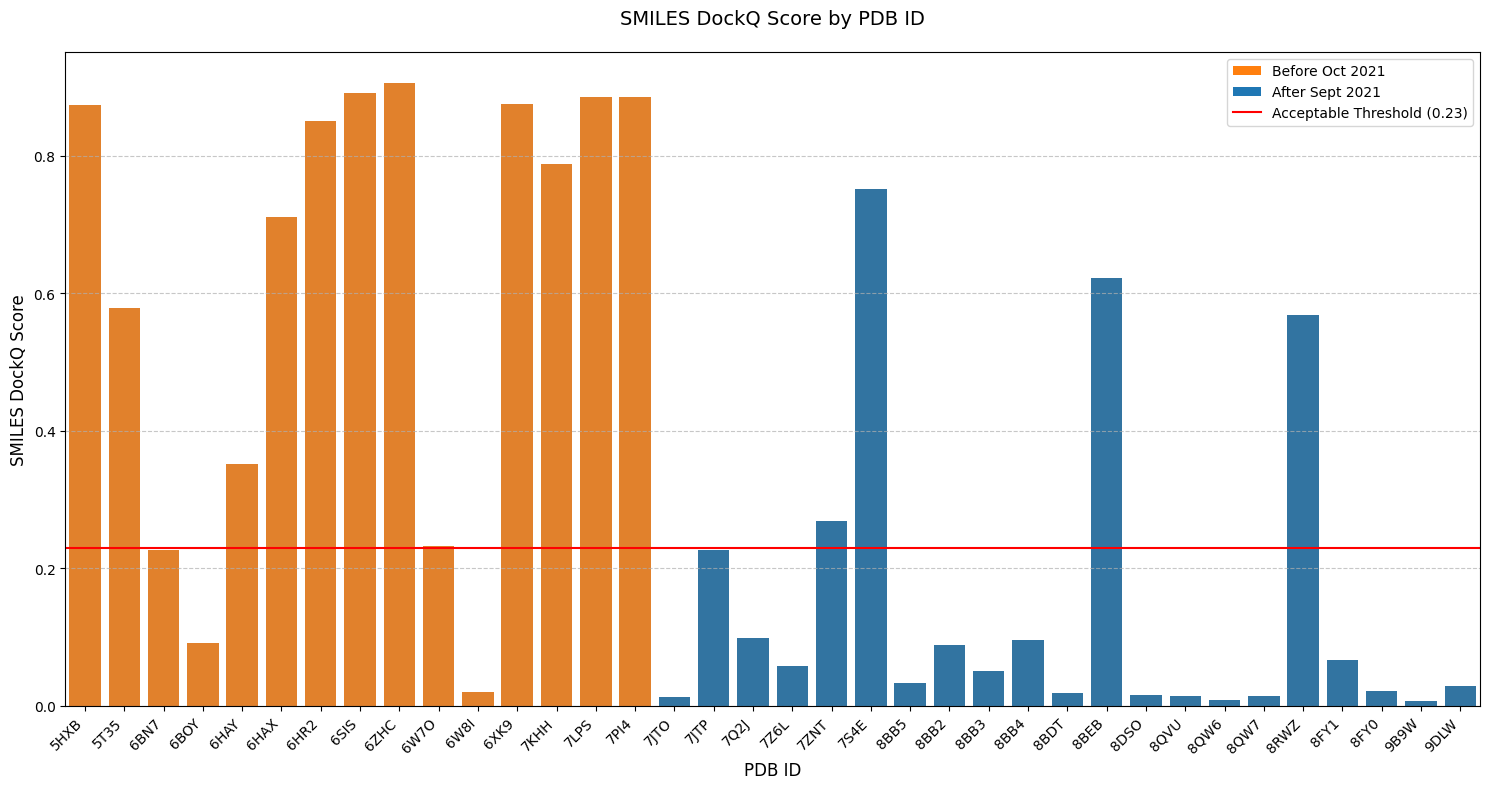

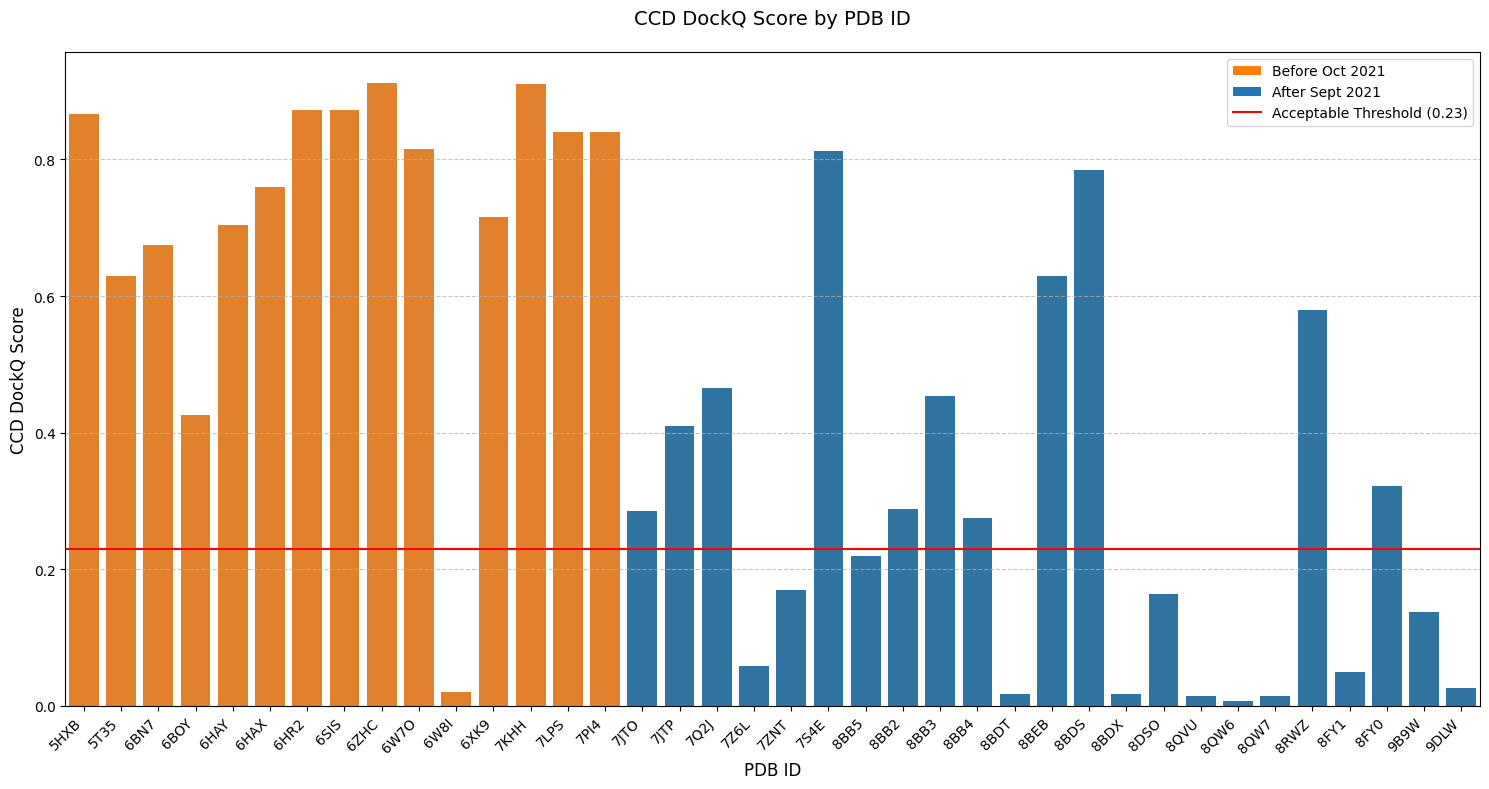

In [79]:
# For DockQ scores
plot_scores(smiles_dockq_df, 'SMILES DockQ Score', add_threshold=True)
plot_scores(ccd_dockq_df, 'CCD DockQ Score', add_threshold=True)

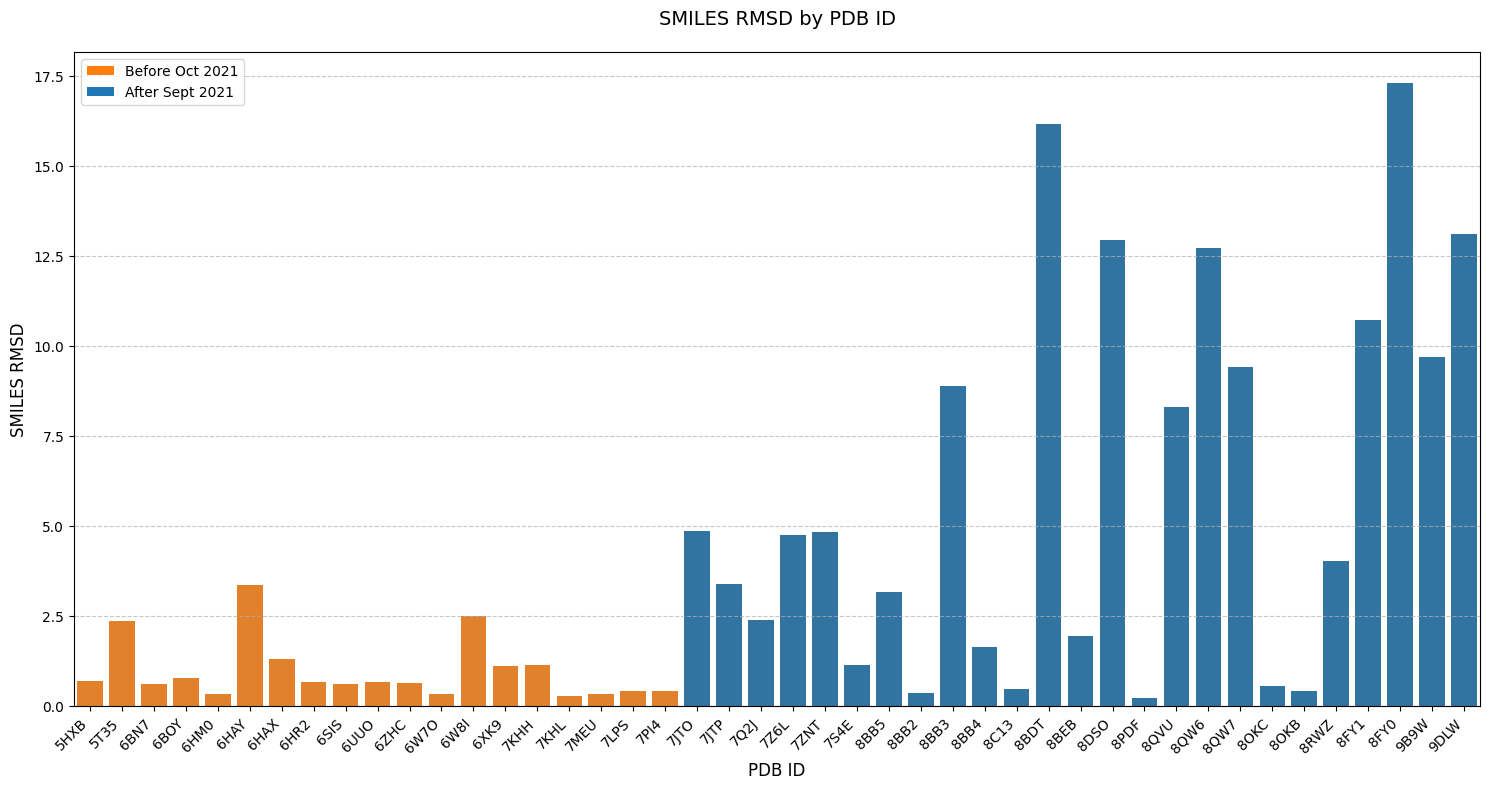

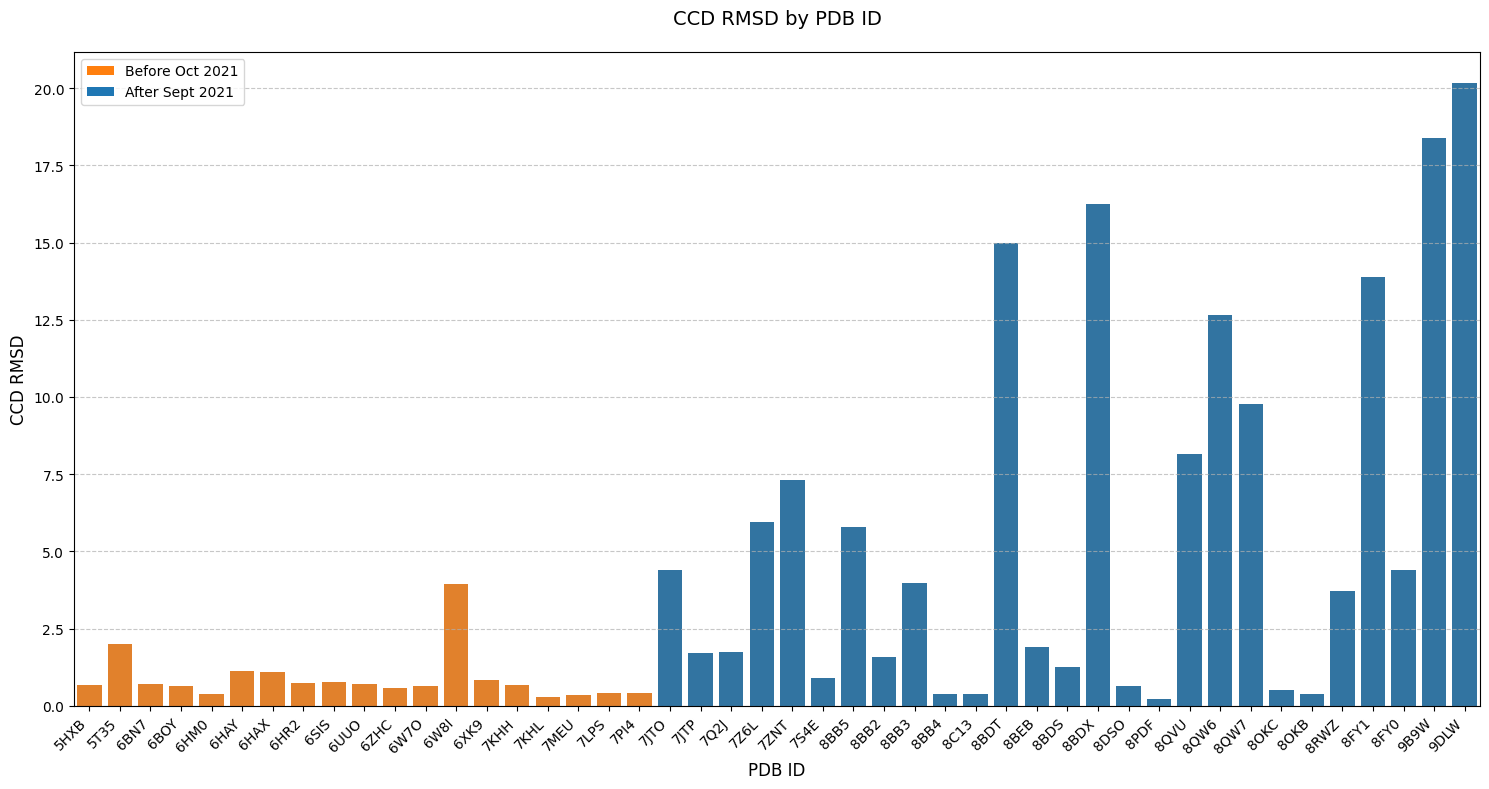

In [80]:
plot_scores(smiles_rmsd_df, 'SMILES RMSD')
plot_scores(ccd_rmsd_df, 'CCD RMSD')

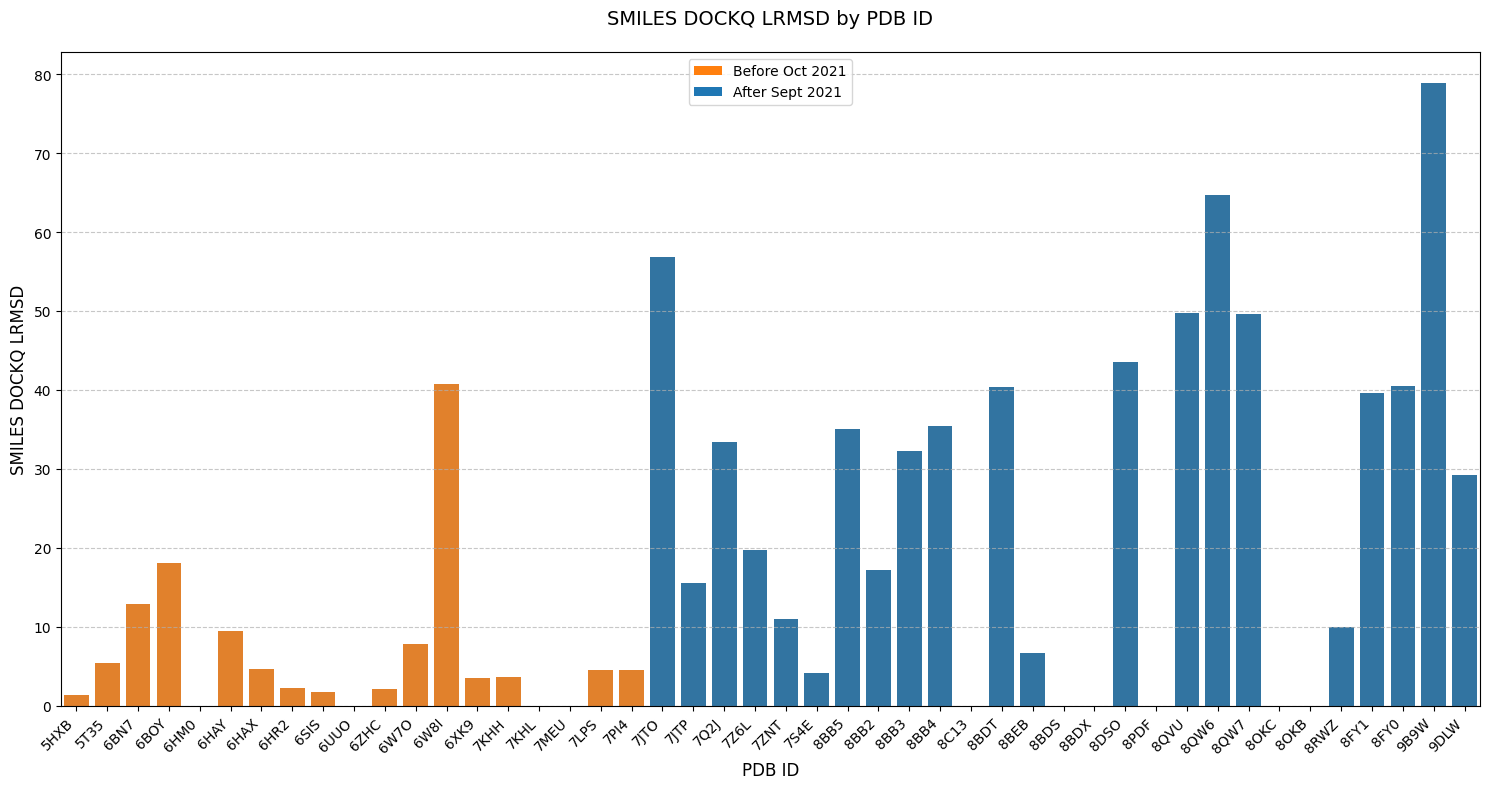

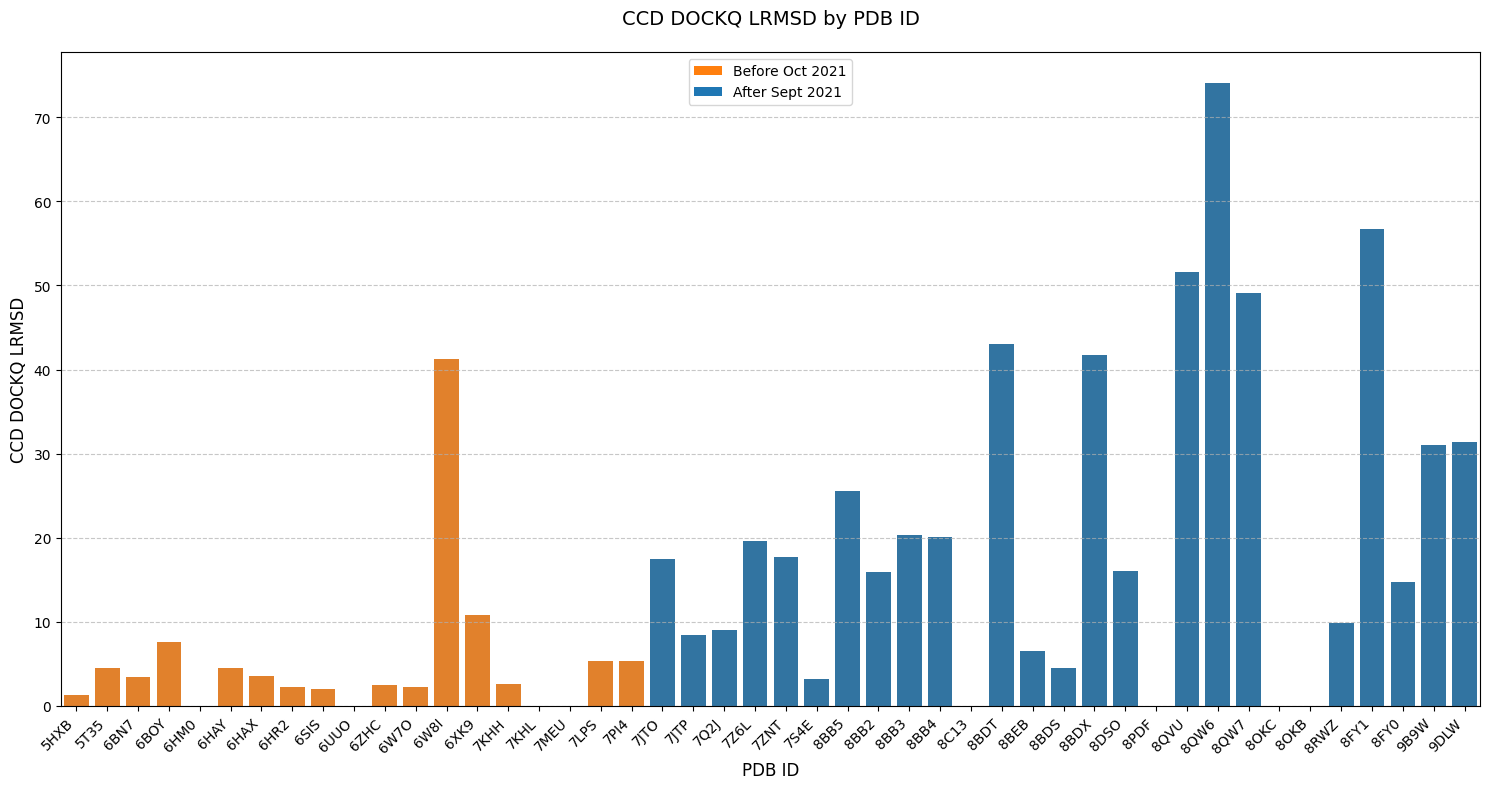

In [81]:
# For LRMSD scores
plot_scores(smiles_lrmsd_df, 'SMILES DOCKQ LRMSD')
plot_scores(ccd_lrmsd_df, 'CCD DOCKQ LRMSD')